# Pre-Processing Methods

For correcting exposure inconsistencies within an image, and performing effective smooothing. 

## Steps:
1. Import list of images
2. Determine settings for bilateral filter (edge-preserving)
3. Find a common correction
4. Loop through images

## Step 1: Import list of images

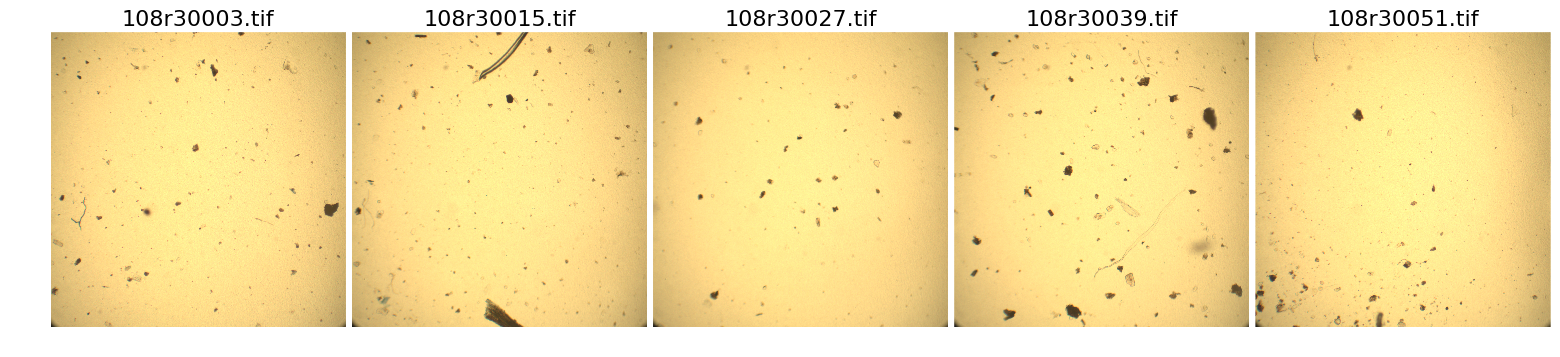

In [1]:
%matplotlib inline

#########################################################################################
dir_in = "/home/patrick/Documents/Jan 20/108rep3/test/"
file_in = ["108r30003.tif", "108r30015.tif", "108r30027.tif", "108r30039.tif", "108r30051.tif"]
#########################################################################################

from matplotlib import pyplot as plt
from skimage import io, color, filters, draw, morphology, exposure, img_as_ubyte, img_as_float, restoration, measure
import pyroots as pr
import numpy as np
from scipy import ndimage
import cv2
from multiprocessing import Pool  
from multiprocessing.dummy import Pool as ThreadPool
import os

img_list = [io.imread(dir_in + i) for i in file_in]
pr.multi_image_plot(img_list, file_in)

## Step 2: Settings for Bilateral Filter

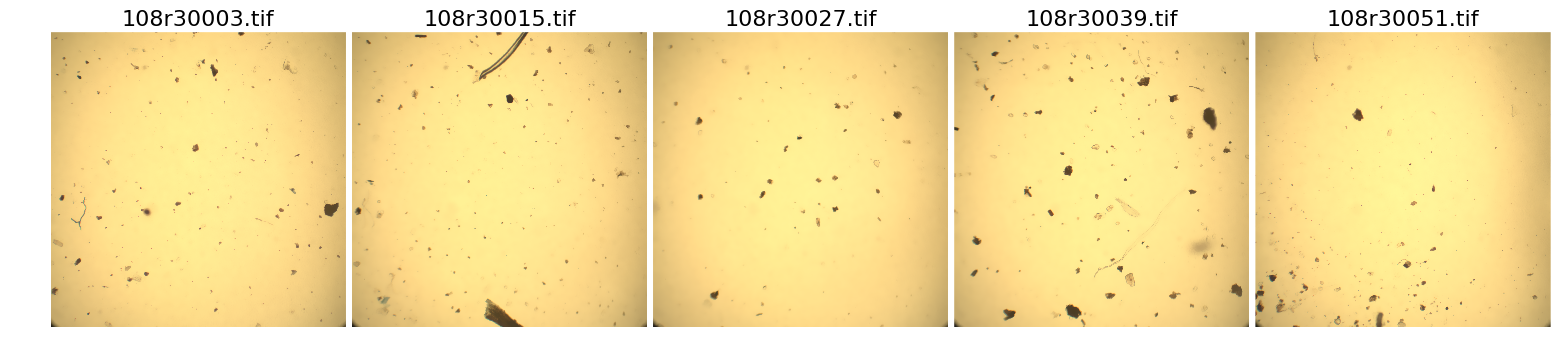

In [2]:
#########################################################################################
bilateral_args = {'sigmaColor' : 25,  # size of gaussian filter (higher smooths more, increases processing)
                  'sigmaSpace' : 15}  # Max difference of influence (higher preserves fewer edges)

test_image = [0, 1, 2, 3, 4]  # what images do you want to run this on? int or list
#########################################################################################

bilat = [cv2.bilateralFilter(img_list[i], -1, **bilateral_args) for i in test_image]

img = bilat
pr.multi_image_plot(img, [file_in[i] for i in test_image])

## Step 3: Common correction

/home/patrick/Programs/scikit-image/skimage/util/dtype.py:118: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


Mean Percentiles: 
[-0.078024230746844808, -0.076489328045293542, -0.069882439658426262, -0.060509072759759891, -0.043204304962338694, -0.022531480362043263, -0.0043867058848234388, 0.045505883724334908, 0.097490963174956854, 0.12829169475585789, 0.15687888082592691, 0.20142437666096161, 0.24737151879014768]

Variation in Mean, percentiles:
[0.0, 2.4955570840664126e-07, 8.6576210247198613e-07, 1.3790832643344229e-06, 2.1335748069806571e-06, 4.1241901746757624e-06, 1.1036627412715776e-05, 2.7830509082642147e-05, 5.2960186491815095e-05, 8.002394131143642e-05, 0.00010573036945436648, 0.00020335700977342779, 0.0003203825930300184]


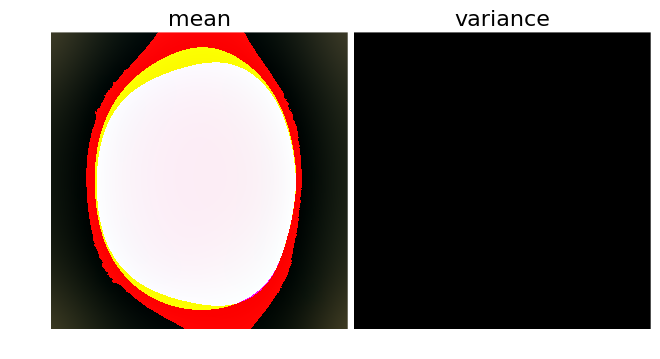

In [4]:
#########################################################################################
exposure_args = {'smooth_iterations' : 3,     # times to run pyroots.equalize_exposure (mean filter, smoothed, as correction)
                 'return_variance'   : True,  # variance of mean correction for each pixel? For diagnostics.
                 'threads'           : 3}     # multiprocessing
#########################################################################################

# s-l-o-w function
calc = False
if calc is True:
    correction, variance = pr.calc_exposure_correction(bilat,
                                                       **exposure_args)

percentiles = [0, 0.5, 2.5, 5, 10, 25, 50, 75, 90, 95, 97.5, 99.5, 100]
print('Mean Percentiles: ')
print([np.percentile(correction, i) for i in percentiles])
print('\nVariation in Mean, percentiles:')
print([np.percentile(variance, i) for i in percentiles])

img = [correction, variance]
pr.multi_image_plot(img, ['mean', 'variance'])

## Step 3: Loop Through Images

In [9]:
def preprocessing_loop(base_directory, image_extension, correction_image, bilateral_args, threads=1,
               out_dir="Pyroots_Preprocessed", save_images=False):

    #Make an output directory for the analyzed images and data.
    if save_images is True:
        if not os.path.exists(base_directory + os.sep + out_dir):
            os.mkdir(base_directory + os.sep + out_dir)  
            
    for subdir, dirs, files in os.walk(base_directory):
        def _core_fn(file_in):
            if file_in.endswith(image_extension) and not subdir.endswith(out_dir):
                path_in = subdir + os.sep + file_in
                path_out = base_directory + os.sep + out_dir + os.sep + subdir[len(base_directory):] + file_in

                img = io.imread(path_in)  # load
                
                img = cv2.bilateralFilter(img, -1, **bilateral_args)  # bilateral filter
                
                img = img_as_float(img) + img_as_float(correction_image)  # correct exposure
                img[img>1] = 1
                img[img<0] = 0

                if save_images is True:
                    io.imsave(path_out, img_as_ubyte(img) ) # save
                
                return(file_in)
            
        # init workers
        # cv2 already uses multicore processing, but loading and saving images also uses lots of resources
        # and should be parallelized
        thread_pool = ThreadPool(threads)
        
        # do it
        out = thread_pool.map(_core_fn, files)
        
        # close
        thread_pool.close()
        thread_pool.join()
        
        return(out)

In [12]:
calc = False
if calc is True:  # S-L-O-W
    x = image_loop("/home/patrick/Documents/Jan 20", 
                   ".tif", 
                   correction, 
                   bilateral_args, 
                   save_images=True, threads=4)

/home/patrick/Programs/scikit-image/skimage/util/dtype.py:118: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan 20/Pyroots_Preprocessed/107r30055.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan 20/Pyroots_Preprocessed/101r30050.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan 20/Pyroots_Preprocessed/108r20057.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/patrick/Programs/scikit-image/skimage/io/_io.py:132: UserWarning: /home/patrick/Documents/Jan 20/Pyroots_Preprocessed/107r10053.tif is a low contrast image
  warn('%s is a low contrast image' % f

In [13]:
x

['108r10076.tif',
 '108r20001.tif',
 '101r20004.tif',
 '108r20056.tif',
 '108r30001.tif',
 '101r20007.tif',
 '101r10067.tif',
 '108r20023.tif',
 '101r20030.tif',
 '108r10044.tif',
 '108r3_edge0020.tif',
 '101r10034.tif',
 '108r20064.tif',
 '107r20058.tif',
 '107r20012.tif',
 '101r20050.tif',
 '101r10062.tif',
 '107r10074.tif',
 '108r3_edge0026.tif',
 '107r30075.tif',
 '108r20014.tif',
 '108r3_edge0037.tif',
 '108r20057.tif',
 '108r10004.tif',
 '101r10023.tif',
 '101r30017.tif',
 '101r20047.tif',
 '101r30047.tif',
 '107r30076.tif',
 '107r30065.tif',
 '107r20057.tif',
 '107r10053.tif',
 '108r20004.tif',
 '108r20041.tif',
 '107r20056.tif',
 '108r10061.tif',
 '108r10060.tif',
 '107r20040.tif',
 '108r10029.tif',
 '101r30035.tif',
 '108r10077.tif',
 '107r10024.tif',
 '101r30018.tif',
 '107r30047.tif',
 '101r20091.tif',
 '101r30050.tif',
 '108r20002.tif',
 '101r20059.tif',
 '101r30010.tif',
 '108r10047.tif',
 '107r20010.tif',
 '108r10012.tif',
 '108r20037.tif',
 '108r20051.tif',
 '108r20010.t